In [1]:
%%capture
%pip install transformers
%pip install bertviz

In [40]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", output_attentions=True)

raw_text = "Hello, my dog is cute"

inputs = tokenizer(raw_text, return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

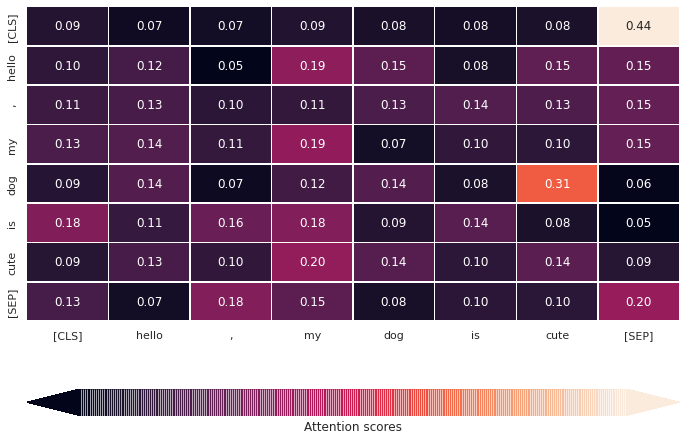

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

enc = tokenizer.encode_plus(
  raw_text,
  add_special_tokens=True,
  return_token_type_ids=False,
  return_attention_mask=False,
  truncation=True
)['input_ids']

text = tokenizer.convert_ids_to_tokens(enc)

output_attention_index = 2
attention_head = 0
layer = 0
batch = 0
attention = outputs.to_tuple()[output_attention_index][layer][batch][attention_head].detach().numpy()
cbar_kws = {"label":"Attention scores", "orientation":"horizontal", 'shrink':1, 'extend':'both', 'extendfrac':0.1, 'ticks':np.arange(0,3), 'drawedges':True }
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(attention, linewidth=0.5, annot=True, xticklabels=text, yticklabels=text, fmt="0.2f", cbar_kws=cbar_kws)
plt.show()

## Positional Encodings

In [ ]:
import numpy as np

def positional_encoding(max_position, d_model, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(d_model)//2)/d_model)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc

pos_enc = positional_encoding(10, 5)
print(pos_enc.shape)
print(pos_enc)

(10, 5)
[[ 1.          0.          1.          0.          1.        ]
 [ 0.54030231  0.84147098  0.99968454  0.02511622  0.9999998 ]
 [-0.41614684  0.90929743  0.99873835  0.0502166   0.9999992 ]
 [-0.9899925   0.14112001  0.99716204  0.07528529  0.99999821]
 [-0.65364362 -0.7568025   0.99495659  0.10030649  0.99999682]
 [ 0.28366219 -0.95892427  0.9921234   0.1252644   0.99999502]
 [ 0.96017029 -0.2794155   0.98866425  0.15014327  0.99999283]
 [ 0.75390225  0.6569866   0.98458133  0.17492742  0.99999025]
 [-0.14550003  0.98935825  0.97987722  0.1996012   0.99998726]
 [-0.91113026  0.41211849  0.97455487  0.22414905  0.99998388]]


## Attention

### Self attention calculations

In [ ]:
import numpy as np
from scipy.special import softmax
import math
from random import choice

# x = np.array([choice([0, 1.,2.]) for _ in range(12)])
x = np.array([1., 0, 1, 0, 0, 2, 0, 2, 1, 1, 1, 1])
x = x.reshape(3,4)

query_w = np.array([1., 0, 1., 1, 0, 0, 0, 0, 1, 0, 1, 1])
query_w = query_w.reshape(4, 3)


key_w = np.array([0, 0, 1., 1, 1, 0, 0, 1, 0, 1, 1, 0])
key_w = key_w.reshape(4, 3)

value_w = np.array([0, 2, 0, 0, 3, 0, 1, 0, 3, 1, 1, 0])
value_w = value_w.reshape(4, 3)

Q = x @ query_w
K = x @ key_w
V = x @ value_w

k_d = int(math.sqrt(3))
print('k_d:', k_d)

attention_score = (Q @ K.transpose())/k_d
print(attention_score)

attention_score = softmax(attention_score, axis=1) # taking softmax across the rows
print("attention_score: ")
print(attention_score)

k_d: 1
[[ 2.  4.  4.]
 [ 4. 16. 12.]
 [ 4. 12. 10.]]
attention_score: 
[[6.33789383e-02 4.68310531e-01 4.68310531e-01]
 [6.03366485e-06 9.82007865e-01 1.79861014e-02]
 [2.95387223e-04 8.80536902e-01 1.19167711e-01]]


### Multi Head attention

In [ ]:
import numpy as np

print("Assuming the training on the 8 heads of the attention sub-layer is done.")
z0h1=np.random.random((3, 64))
z1h2=np.random.random((3, 64))
z2h3=np.random.random((3, 64))
z3h4=np.random.random((3, 64))
z4h5=np.random.random((3, 64))
z5h6=np.random.random((3, 64))
z6h7=np.random.random((3, 64))
z7h8=np.random.random((3, 64))
print("shape of one head", z0h1.shape, "dimension of 8 heads", 64*8)

print("Concatenation of heads 1 to 8 to obtain the original 8x64=512 output dimension of the model")
output_attention=np.hstack((z0h1, z1h2, z2h3, z3h4, z4h5, z5h6, z6h7, z7h8))
print('final output shape', output_attention.shape)

Assuming the training on the 8 heads of the attention sub-layer is done.
shape of one head (3, 64) dimension of 8 heads 512
Concatenation of heads 1 to 8 to obtain the original 8x64=512 output dimension of the model
final output shape (3, 512)


### Masked Multi Head attention

In [ ]:
import numpy as np
import numpy.ma as ma
import math

print('original attention scores (after scaling)')
print(attention_score)

zeros = np.zeros(attention_score.shape)
mx = ma.masked_array(zeros, mask=[0, 1, 1, 0, 0, 1, 0, 0, 0], fill_value=1e+20)

print('masked values')
print(mx)

print('fill the mask')
mx = mx.filled(fill_value=float('-inf'))

print('add the masking')
attention_score1 = attention_score + mx
print(attention_score1)

attention_score1 = softmax(attention_score1, axis=1) # taking softmax across the rows
print(attention_score1)

original attention scores (after scaling)
[[6.33789383e-02 4.68310531e-01 4.68310531e-01]
 [6.03366485e-06 9.82007865e-01 1.79861014e-02]
 [2.95387223e-04 8.80536902e-01 1.19167711e-01]]
masked values
[[0.0 -- --]
 [0.0 0.0 --]
 [0.0 0.0 0.0]]
fill the mask
add the masking
[[6.33789383e-02           -inf           -inf]
 [6.03366485e-06 9.82007865e-01           -inf]
 [2.95387223e-04 8.80536902e-01 1.19167711e-01]]
[[1.         0.         0.        ]
 [0.27249476 0.72750524 0.        ]
 [0.22037557 0.53143172 0.24819272]]
